In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import os, sys
import itertools
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
import statsmodels.stats.api as sms

module_path = '/home/wsliu/Codes/DLproj'
if module_path not in sys.path:
    sys.path.append(module_path)
if module_path+'/NRD' not in sys.path:
    sys.path.append(module_path+'/NRD')
from DL_utils import parallel_coordinates

In [2]:
path = '/nfs/turbo/umms-awaljee/wsliu/Data/MIMIC/'

## Editing pbs Files

In [14]:
!rm batch*.pbs

In [4]:
for job_index in range(4):
    with open('batch{}.pbs'.format(job_index), 'w') as f:
        f.write("""#!/bin/sh

#### PBS preamble

#PBS -N MIMIC_hypertune{}

#PBS -M wsliu@umich.edu
#PBS -m abe

#PBS -A awaljee_fluxod

#PBS -q fluxod

#PBS -V
#PBS -l nodes=1:ppn={},mem={}gb,walltime={}:00:00
#PBS -j oe

#### End PBS preamble

#  Show list of CPUs you ran on, if you're running under PBS
if [ -n "$PBS_NODEFILE" ]; then cat $PBS_NODEFILE; fi

#  Change to the directory you submitted from
if [ -n "$PBS_O_WORKDIR" ]; then cd $PBS_O_WORKDIR; fi

#  Put your job commands here:
sh hypertune{}.sh""".format(job_index, '1', 8, 36, job_index))

In [15]:
for job_index in range(20):
    with open('batch_gpu{}.pbs'.format(job_index), 'w') as f:
        f.write("""#!/bin/sh

#### PBS preamble

#PBS -N MIMIC_hypertune{}

#PBS -M wsliu@umich.edu
#PBS -m abe

#PBS -A awaljee_fluxg

#PBS -q fluxg

#PBS -V
#PBS -l nodes=1:gpus={},mem={}gb,walltime={}:00:00
#PBS -j oe

#### End PBS preamble

#  Show list of CPUs you ran on, if you're running under PBS
if [ -n "$PBS_NODEFILE" ]; then cat $PBS_NODEFILE; fi

#  Change to the directory you submitted from
if [ -n "$PBS_O_WORKDIR" ]; then cd $PBS_O_WORKDIR; fi

#  Put your job commands here:
sh hypertune{}.sh""".format(job_index, '1', 8, 72, job_index))

## Prepare hyper-parameters and generate the .sh files

For 2-step glove with a subset of codes:

In [75]:
!rm hypertune*.sh

In [69]:
model_names = ['setsum_nn']
code_embed_dims = [30]
fc_widths = [512]
md_widths = [5]
lr1s = [5e-4]
lr2s = [5e-5]
dropouts = [0.3]
batchsizes = [512]
embed_mats = ['pretrain']
#penalties = [0]
#penalty_metrics = ['cosine']
count_caps = [72]
tst_seeds = range(10)
code_rarecutpoints = [40]
val_folds = [5]
class_weights = [1.]
semi_proportions = [1.0]
outcomes = ['MOT_1year', 'MOT_30days']
result_files = ['output/ht_result0430_{}.csv']

In [76]:
model_names = ['setsum_nn']
code_embed_dims = [20, 30, 50, 100, 200]
fc_widths = [512]
md_widths = [5]
lr1s = [5e-4]
lr2s = [5e-5]
dropouts = [0.3]
batchsizes = [512]
embed_mats = ['pretrain']
#penalties = [0]
#penalty_metrics = ['cosine']
count_caps = [72]
tst_seeds = range(10)
code_rarecutpoints = [40]
val_folds = [5]
class_weights = [1.]
semi_proportions = [1.0]
outcomes = ['MOT_1year', 'MOT_30days']
result_files = ['output/ht_result0430_{}.csv']

In [80]:
model_names = ['setsum_nn']
code_embed_dims = [30]
fc_widths = [512]
md_widths = [5]
lr1s = [5e-4]
lr2s = [5e-5]
dropouts = [0.3]
batchsizes = [512]
embed_mats = ['pretrain']
#penalties = [0]
#penalty_metrics = ['cosine']
count_caps = [72]
tst_seeds = range(10)
code_rarecutpoints = [0, 2, 5, 10, 20, 30, 40, 50, 100]
val_folds = [5]
class_weights = [1.]
semi_proportions = [1.0]
outcomes = ['MOT_1year', 'MOT_30days']
result_files = ['output/ht_result0430_{}.csv']

In [84]:
model_names = ['setsum_nn']
code_embed_dims = [30]
fc_widths = [512]
md_widths = [5]
lr1s = [5e-4]
lr2s = [5e-5]
dropouts = [0.3]
batchsizes = [512]
embed_mats = ['pretrain']
#penalties = [0]
#penalty_metrics = ['cosine']
count_caps = [72]
tst_seeds = range(10)
code_rarecutpoints = [40]
val_folds = [5]
class_weights = [1.]
semi_proportions = [0.3, 0.5, 0.7, 0.8, 0.9, 1.0]
outcomes = ['MOT_1year', 'MOT_30days']
result_files = ['output/ht_result0430_{}.csv']

In [88]:
model_names = ['setsum_nn']
code_embed_dims = [30]
fc_widths = [512]
md_widths = [5]
lr1s = [5e-4]
lr2s = [5e-5]
dropouts = [0.3]
batchsizes = [512]
embed_mats = ['pretrain']
#penalties = [0]
#penalty_metrics = ['cosine']
count_caps = [72]
tst_seeds = range(10)
code_rarecutpoints = [40]
val_folds = [5]
class_weights = [1., 5., 10., 15.]
semi_proportions = [1.0]
outcomes = ['MOT_1year', 'MOT_30days']
result_files = ['output/ht_result0430_{}.csv']

In [89]:
para_itr = itertools.product(model_names, code_embed_dims, fc_widths, md_widths, lr1s, lr2s, dropouts, batchsizes, embed_mats, 
                             count_caps, tst_seeds, code_rarecutpoints, val_folds, class_weights, semi_proportions, outcomes, 
                             result_files)
para_lst = list(para_itr)

In [90]:
len(para_lst)

80

In [91]:
n_jobs = 20
for para, job_ind in zip(para_lst, itertools.cycle(range(n_jobs))):
    with open('hypertune'+str(job_ind)+'.sh', 'a') as f:
        f.write('python train_template_sub0228.py --model_name {} --code_embed_dim {} --fc_width {} --md_width {} --lr1 {} --lr2 {} --dropout {} --batchsize {} --embed_file {} --count_cap {} --tst_seed {} --code_rarecutpoint {} --val_fold {} --class_weight {} --semi_proportion {} --outcome {} --result_file {} --job_index {}\n'.format(*para, job_ind))

In [6]:
job_index = 10
for para in para_lst:
    with open('hypertune'+str(job_index)+'.sh', 'a') as f:
        f.write('python train_template_sub0922.py --model_name {0} --code_embed_dim {1} --fc_width {2} --md_width {3} --lr1 {4} --lr2 {5} --dropout {6} --batchsize {7} --embed_file {8} --penalty {9} --penalty_metric {10} --count_cap {11} --tst_seed {12} --cohort {13} --dx_rarecutpoint {14} --pr_rarecutpoint {15} --val_fold {16} --result_file {17} --job_index {18}\n'.format(*para, job_index))

Random search:

In [52]:
n_sample = 5000

In [57]:
model_names = np.random.choice(['setsum_nn'], n_sample)
code_embed_dims = np.random.choice(range(20, 150), n_sample)
fc_widths = np.random.choice(range(64, 500), n_sample)
md_widths = np.random.choice(range(4, 100), n_sample)
lr1s = np.random.choice([5e-4], n_sample)
lr2s = np.random.choice([5e-5], n_sample)
dropouts = np.random.choice([0.3], n_sample)
batchsizes = np.random.choice([256, 512], n_sample)
embed_mats = np.random.choice(['pretrain'], n_sample)
#penalties = np.random.choice([0, 0.5, 1.], n_sample)
#penalty_metrics = np.random.choice(['cosine'], n_sample)
count_caps = np.random.choice(range(100), n_sample)
code_rarecutpoints = np.random.choice(range(1, 100), n_sample)
val_folds = np.random.choice([5], n_sample)
class_weights = np.random.choice(range(1, 16), n_sample)
result_files = ['output/ht_result0314_{}.csv']*n_sample

In [58]:
zips = zip(model_names, code_embed_dims, fc_widths, md_widths, lr1s, lr2s, dropouts, batchsizes, embed_mats, 
                             count_caps, code_rarecutpoints, val_folds, class_weights, result_files)
tst_seeds = range(1)

In [59]:
para_itr = itertools.product(zips, tst_seeds)

para_lst = [(*z, t) for z, t in para_itr]

In [60]:
len(para_lst)

5000

In [61]:
n_jobs = 10
for para, job_ind in zip(para_lst, itertools.cycle(range(n_jobs))):
    with open('hypertune'+str(job_ind)+'.sh', 'a') as f:
        f.write('python train_template_sub0228.py --model_name {} --code_embed_dim {} --fc_width {} --md_width {} --lr1 {} --lr2 {} --dropout {} --batchsize {} --embed_file {} --count_cap {} --code_rarecutpoint {} --val_fold {} --class_weight {} --result_file {} --tst_seed {} --job_index {}\n'.format(*para, job_ind))

In [8]:
n_jobs = 4
for para, job_ind in zip(para_lst, itertools.cycle(range(n_jobs))):
    with open('hypertune'+str(job_ind)+'.sh', 'a') as f:
        f.write('python train_template_sub0922.py --model_name {0} --code_embed_dim {1} --fc_width {2} --md_width {3} --lr1 {4} --lr2 {5} --dropout {6} --batchsize {7} --embed_file {8} --penalty {9} --penalty_metric {10} --count_cap {11} --cohort {12} --dx_rarecutpoint {13} --pr_rarecutpoint {14} --val_fold {15} --result_file {16} --tst_seed {17} --job_index {18}\n'.format(*para, job_ind))

## Result Analysis

### Embedding + NN  with subset of codes

In [3]:
res = pd.DataFrame()

for job_ind in range(20):
    df = pd.read_csv('output/ht_result0430_'+str(job_ind)+'.csv', 
                     names=['model_name', 'code_embed_dim', 'fc_width', 'md_width', 'lr1', 'lr2', 'dropout',
                            'batchsize', 'embed_file', 'tst_seed', 'n_fold', 'count_cap', 'code_rarecutpoint', 
                            'minor_class_weight', 'auc_mean', 'auc_freeze', 'n_sample', 'n_code', 'semi_proportion', 
                           'outcome', 'n_train_sample'], index_col=False)
    res = pd.concat([res, df])

In [4]:
res.head()

,model_name,code_embed_dim,fc_width,md_width,lr1,lr2,dropout,batchsize,embed_file,tst_seed,...,count_cap,code_rarecutpoint,minor_class_weight,auc_mean,auc_freeze,n_sample,n_code,semi_proportion,outcome,n_train_sample
0,setsum_nn,20,512,5,0.0005,0.00005,0.3,512,pretrain,0,...,72,40,1.0,0.86823,0.86296,44854,1744,1.0,MOT_1year,35897
1,setsum_nn,30,512,5,0.0005,0.00005,0.3,512,pretrain,0,...,72,40,1.0,0.86911,0.86388,44854,1744,1.0,MOT_1year,35897
2,setsum_nn,50,512,5,0.0005,0.00005,0.3,512,pretrain,0,...,72,40,1.0,0.87192,0.86621,44854,1744,1.0,MOT_1year,35897
3,setsum_nn,100,512,5,0.0005,0.00005,0.3,512,pretrain,0,...,72,40,1.0,0.87224,0.86749,44854,1744,1.0,MOT_1year,35897
4,setsum_nn,200,512,5,0.0005,0.00005,0.3,512,pretrain,0,...,72,40,1.0,0.87125,0.87104,44854,1744,1.0,MOT_1year,35897


In [5]:
res.shape

(480, 21)

In [25]:
parallel_coord_df = res[['code_embed_dim', 'fc_width', 'md_width', 'count_cap', 'code_rarecutpoint', 'minor_class_weight',
                         'auc_freeze']]

In [26]:
parallel_coord_df.columns = ['code_embed_dim', 'fc_width', 'md_width', 'count_cap', 'code_rarecutpoint', 'minor_class_weight',
                             'score']

In [27]:
dict_lst = []
for _, r in parallel_coord_df.iterrows():
    dict_lst.append(r.to_dict())

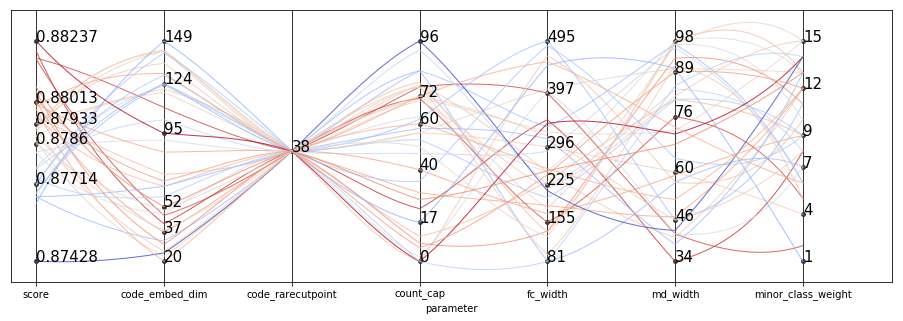

In [28]:
parallel_coordinates(dict_lst)

In [36]:
good = res.loc[(res.auc_freeze>0.87) & (res.code_rarecutpoint==38)]

In [37]:
good.shape

(48, 18)

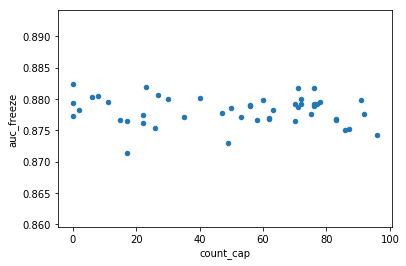

In [38]:
good.plot.scatter('code_embed_dim', 'auc_freeze')

In [6]:
res.to_csv('output/ht_result0430.csv', index=False)

In [36]:
res = pd.read_csv('output/ht_result0430.csv')

In [8]:
res.code_embed_dim.value_counts()

30     400
200     20
100     20
50      20
20      20
Name: code_embed_dim, dtype: int64

In [37]:
res = res.loc[(res.minor_class_weight==1) & (res.code_rarecutpoint==40) & (res.semi_proportion>0)&(res.code_embed_dim==30)
             &(res.outcome=='MOT_1year')]

In [12]:
res.shape

(120, 21)

In [34]:
var = 'semi_proportion'

In [38]:
res[[var, 'auc_freeze', 'auc_mean']].groupby(var).mean().transpose()

semi_proportion,0.3,0.5,0.7,0.8,0.9,1.0
auc_freeze,0.848767,0.857265,0.860982,0.864700,0.865505,0.864333
auc_mean,0.851750,0.860859,0.864677,0.868124,0.869466,0.868904


## For supervised Glove

In [17]:
!rm hypertune*.sh

In [18]:
model_names = ['setsum_nn']
code_embed_dims = [30]
fc_widths = [512]
md_widths = [5]
lrs = [5e-4]
dropouts = [0.3]
batchsizes = [512]
embed_mats = ['pretrain']
#penalties = [0]
#penalty_metrics = ['cosine']
count_caps = [72]
tst_seeds = range(10)
code_rarecutpoints = [0]
val_folds = [5]
class_weights = [1.]
semi_proportions = [1.0]
outcomes = ['MOT_1year', 'MOT_30days']
batchsize_ratios = [20]
loss_weights = [20.]
result_files = ['output/ht_result0429_{}.csv']

In [22]:
model_names = ['setsum_nn']
code_embed_dims = [20, 30, 50, 100, 200]
fc_widths = [512]
md_widths = [5]
lrs = [5e-4]
dropouts = [0.3]
batchsizes = [512]
embed_mats = ['pretrain']
#penalties = [0]
#penalty_metrics = ['cosine']
count_caps = [72]
tst_seeds = range(10)
code_rarecutpoints = [40]
val_folds = [5]
class_weights = [1.]
semi_proportions = [1.0]
outcomes = ['MOT_1year', 'MOT_30days']
batchsize_ratios = [20]
loss_weights = [20.]
result_files = ['output/ht_result0429_{}.csv']

In [26]:
model_names = ['setsum_nn']
code_embed_dims = [30]
fc_widths = [512]
md_widths = [5]
lrs = [5e-4]
dropouts = [0.3]
batchsizes = [512]
embed_mats = ['pretrain']
#penalties = [0]
#penalty_metrics = ['cosine']
count_caps = [72]
tst_seeds = range(10)
code_rarecutpoints = [0, 2, 5, 10, 20, 30, 40, 50, 100]
val_folds = [5]
class_weights = [1.]
semi_proportions = [1.0]
outcomes = ['MOT_1year', 'MOT_30days']
batchsize_ratios = [20]
loss_weights = [20.]
result_files = ['output/ht_result0429_{}.csv']

In [34]:
model_names = ['setsum_nn']
code_embed_dims = [30]
fc_widths = [512]
md_widths = [5]
lrs = [5e-4]
dropouts = [0.3]
batchsizes = [512]
embed_mats = ['pretrain']
#penalties = [0]
#penalty_metrics = ['cosine']
count_caps = [72]
tst_seeds = range(10)
code_rarecutpoints = [40]
val_folds = [5]
class_weights = [1.]
semi_proportions = [0.3, 0.5, 0.7, 0.8, 0.9, 1.0]
outcomes = ['MOT_1year', 'MOT_30days']
batchsize_ratios = [20]
loss_weights = [20.]
result_files = ['output/ht_result0429_{}.csv']

In [38]:
model_names = ['setsum_nn']
code_embed_dims = [30]
fc_widths = [512]
md_widths = [5]
lrs = [5e-4]
dropouts = [0.3]
batchsizes = [512]
embed_mats = ['pretrain']
#penalties = [0]
#penalty_metrics = ['cosine']
count_caps = [72]
tst_seeds = range(10)
code_rarecutpoints = [40]
val_folds = [5]
class_weights = [1., 5., 10., 15.]
semi_proportions = [1.0]
outcomes = ['MOT_1year', 'MOT_30days']
batchsize_ratios = [20]
loss_weights = [20.]
result_files = ['output/ht_result0429_{}.csv']

In [19]:
para_itr = itertools.product(model_names, code_embed_dims, fc_widths, md_widths, lrs, dropouts, batchsizes, embed_mats, 
                             count_caps, tst_seeds, code_rarecutpoints, val_folds, class_weights, semi_proportions, outcomes,
                             batchsize_ratios, loss_weights, result_files)
para_lst = list(para_itr)

In [20]:
len(para_lst)

20

In [21]:
job_indicies = range(20)
for para, job_ind in zip(para_lst, itertools.cycle(job_indicies)):
    with open('hypertune'+str(job_ind)+'.sh', 'a') as f:
        f.write('python template_supervise_glove.py --model_name {} --code_embed_dim {} --fc_width {} --md_width {} --lr {} --dropout {} --batchsize {} --embed_file {} --count_cap {} --tst_seed {} --code_rarecutpoint {} --val_fold {} --class_weight {} --semi_proportion {} --outcome {} --batchsize_ratio {} --loss_weight {} --result_file {} --job_index {}\n'.format(*para, job_ind))

In [6]:
job_index = 10
for para in para_lst:
    with open('hypertune'+str(job_index)+'.sh', 'a') as f:
        f.write('python train_template_sub0922.py --model_name {0} --code_embed_dim {1} --fc_width {2} --md_width {3} --lr1 {4} --lr2 {5} --dropout {6} --batchsize {7} --embed_file {8} --penalty {9} --penalty_metric {10} --count_cap {11} --tst_seed {12} --cohort {13} --dx_rarecutpoint {14} --pr_rarecutpoint {15} --val_fold {16} --result_file {17} --job_index {18}\n'.format(*para, job_index))

### Results

In [22]:
res = pd.DataFrame()

for job_ind in range(20):
    df = pd.read_csv('output/ht_result0429_'+str(job_ind)+'.csv', 
                     names=['model_name', 'code_embed_dim', 'fc_width', 'md_width', 'lr', 'dropout',
                            'batchsize', 'embed_file', 'tst_seed', 'n_fold', 'count_cap', 
                            'code_rarecutpoint', 'minor_class_weight', 'batchsize_ratio', 'loss_weight', 'semi_proportion', 
                            'outcome', 'auc_mean', 'n_sample', 'n_code'], index_col=False)
    res = pd.concat([res, df])

In [4]:
res.head()

,model_name,code_embed_dim,fc_width,md_width,lr,dropout,batchsize,embed_file,tst_seed,n_fold,count_cap,code_rarecutpoint,minor_class_weight,batchsize_ratio,loss_weight,semi_proportion,outcome,auc_mean,n_sample,n_code
0,setsum_nn,20,512,5,0.0005,0.3,512,pretrain,0,5,72,30,1.0,20,20.0,1.0,MOT_1year,0.87791,44935,1958
1,setsum_nn,20,512,5,0.0005,0.3,512,pretrain,4,5,72,30,1.0,20,20.0,1.0,MOT_1year,0.87865,44935,1958
2,setsum_nn,20,512,5,0.0005,0.3,512,pretrain,8,5,72,30,1.0,20,20.0,1.0,MOT_1year,0.86408,44935,1958
3,setsum_nn,30,512,5,0.0005,0.3,512,pretrain,2,5,72,30,1.0,20,20.0,1.0,MOT_1year,0.87371,44935,1958
4,setsum_nn,30,512,5,0.0005,0.3,512,pretrain,6,5,72,30,1.0,20,20.0,1.0,MOT_1year,0.85393,44935,1958


In [23]:
res.shape

(20, 20)

In [54]:
parallel_coord_df = res[['loss_weight', 'batchsize_ratio',
                         'auc_mean']]

In [55]:
parallel_coord_df.columns = ['loss_weight', 'batchsize_ratio',
                             'score']

In [56]:
dict_lst = []
for _, r in parallel_coord_df.iterrows():
    dict_lst.append(r.to_dict())

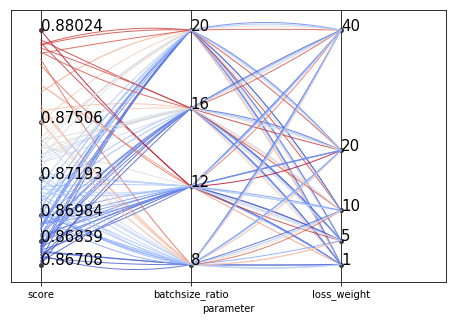

In [57]:
parallel_coordinates(dict_lst)

In [6]:
res.to_csv('output/ht_result0429.csv', index=False)

In [64]:
res = pd.read_csv('output/ht_result0429.csv')

In [31]:
res.code_rarecutpoint.value_counts()

40     320
100     20
50      20
30      20
20      20
10      20
5       20
2       20
0       20
Name: code_rarecutpoint, dtype: int64

In [65]:
res = res.loc[(res.minor_class_weight==1) & (res.code_rarecutpoint==40) & (res.semi_proportion>0)&(res.code_embed_dim==30)
             &(res.outcome=='MOT_1year')]

In [37]:
res.shape

(80, 20)

In [66]:
var = 'semi_proportion'

In [67]:
res[[var, 'auc_mean']].groupby(var).mean().transpose()

semi_proportion,0.3,0.5,0.7,0.8,0.9,1.0
auc_mean,0.860093,0.865548,0.869784,0.870323,0.87111,0.872068
